In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("Trips_2018.csv")

#Remove unwanted index column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

#Convert start and stop times to proper datetime format
df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#Create a new column 'start_hour' — the trip’s start time rounded down to the hour (used later to join with hourly weather data)
df["start_hour"] = df["starttime"].dt.floor("H")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates ensures one central location (e.g., NYC center)
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#Find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

#Print a quick summary
print(f"Trips: {len(df)}  |  Date span: {START} → {END}")
df.head()

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_10220\901575409.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["start_hour"] = df["starttime"].dt.floor("H")


Trips: 17548339  |  Date span: 2018-01-01 → 2018-12-31


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,trip_duration_min
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01 13:00:00,16.166667
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01 15:00:00,12.050000
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01 15:00:00,8.266667
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01 15:00:00,5.100000
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01 18:00:00,5.100000


In [4]:
# --- Weather by small spatial grid (fast, robust, with fallback) ---
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

# 1) Build a small grid (≈2–3 km) to reduce API calls
GRID = 0.03  # ↑ 0.05 fewer calls, ↓ 0.02 more detail

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


# 2) Helper: polite, retrying fetch per cell
def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars)  # more robust than list for some clients
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    # downcast floats to save memory
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1))  # gentle backoff
    # Uncomment for debugging:
    # print(f"Fetch failed for ({lat:.4f},{lon:.4f}): {last_err}")
    return None


# 3) Fetch once per cell
cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2)  # pacing

# --- Fallback if everything failed: use single (city-median) point ---
if not cell_weather:
    print("⚠️ All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # 4) If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    # Stations use their own cell if fetched, otherwise the nearest fetched cell
    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

# 5) Expand cell weather back to stations
wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))


Unique grid cells to fetch: 26
Weather rows (cells): 227760 | cells covered: 26
Total weather rows (expanded to stations): 8050440


In [5]:
# === Merge trips with hourly weather ===

is_station_level = "start_station_id" in wx.columns
key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

# keep only weather fields we actually need (saves memory) if present
wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]
wx_keyed = wx[[c for c in wanted_wx if c in wx.columns]].drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          # keep all trips/columns from df
    validate="m:1"       # many trips to one weather row
)

# merge quality
miss_pct = dfm["temperature_2m"].isna().mean() * 100
print(f"Merge complete | rows={len(dfm):,} | weather coverage={100 - miss_pct:.1f}%")

dfm.head()

Merging on: ['start_hour', 'start_station_id']
Merge complete | rows=17,548,339 | weather coverage=100.0%


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,start_hour,trip_duration_min,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,relative_humidity_2m,cloud_cover,visibility
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,2018-01-01 13:00:00,16.166667,-8.1,-14.9,0.0,0.0,20.400000,30,0,None
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,2018-01-01 15:00:00,12.050000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,2018-01-01 15:00:00,8.266667,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,2018-01-01 15:00:00,5.100000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,2018-01-01 18:00:00,5.100000,-10.0,-15.0,0.0,0.0,7.400000,39,23,None


In [6]:
# === Feature engineering: concise, robust, memory-friendly ===

need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# 1) Temperature (°C) + readable buckets
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# 4) Cycling Score (0–100): temp comfort 40% + dryness 30% + low wind 20% + visibility 10%
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 40           # temperature comfort peak ~20°C
    + dfm["is_dry"] * 30                                           # dry bonus
    + (dfm["wind_kmh"] < 20).astype("int8") * 20                   # calm wind
    + (dfm["visibility_km"] > 5).astype("int8") * 10               # clear view
).clip(0, 100)

# 5) Compact memory for categories
dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()


Weather features added | shape=(17548339, 30) | new cols: ['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,relative_humidity_2m,cloud_cover,visibility,temp_celsius,temp_category,is_dry,wind_kmh,sky_condition,visibility_km,cycling_score
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,30,0,NaN,-8.1,freezing,1,73.439995,clear,NaN,30.014887
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,39,23,NaN,-10.0,freezing,1,26.639999,clear,NaN,30.004936


In [7]:
print("\n" + "="*70)
print("PREPARING FULL DATASET FOR ANALYSIS")
print("="*70)

# Add temporal columns needed for analysis
dfm['day_of_week'] = dfm['starttime'].dt.dayofweek
dfm['is_weekend'] = (dfm['day_of_week'] >= 5).astype(int)
dfm['hour'] = dfm['start_hour'].dt.hour
dfm['month'] = dfm['starttime'].dt.month

print(f"Dataset ready: {len(dfm):,} trips with weather and temporal features")


PREPARING FULL DATASET FOR ANALYSIS
Dataset ready: 17,548,339 trips with weather and temporal features


In [8]:
print("\n" + "="*70)
print("PROCESSING FULL DATASET IN BATCHES (SINGLE PASS)")
print("="*70)

# Initialize containers
BATCH_SIZE = 1000000
all_transactions = []
route_counter = {}
user_profiles_list = []

print(f"Processing {len(dfm):,} trips in batches of {BATCH_SIZE:,}")

# Single pass through dataset
for batch_num, i in enumerate(range(0, len(dfm), BATCH_SIZE), 1):
    batch_end = min(i + BATCH_SIZE, len(dfm))
    batch = dfm.iloc[i:batch_end]
    
    # APRIORI: Create transactions
    batch_clean = batch.dropna(subset=['start_station_id', 'end_station_id'])
    
    batch_transactions = []
    for _, row in batch_clean.iterrows():
        try:
            start = int(row['start_station_id'])
            end = int(row['end_station_id'])
        except:
            continue
        
        transaction = [
            f"route_{start}_to_{end}",
            f"start_{start}",
            f"end_{end}",
        ]
        
        hour = row['start_hour'].hour
        if 7 <= hour <= 9:
            transaction.append("morning_commute")
        elif 17 <= hour <= 19:
            transaction.append("evening_commute")
        else:
            transaction.append("non_commute")
        
        if row['cycling_score'] >= 70:
            transaction.append("good_weather")
        else:
            transaction.append("poor_weather")
        
        batch_transactions.append(transaction)
        route_key = f"{start}_to_{end}"
        route_counter[route_key] = route_counter.get(route_key, 0) + 1
    
    all_transactions.extend(batch_transactions)
    
    # CLUSTERING: Create user profiles
    batch_profiles = batch.groupby(['birth_year', 'gender']).agg({
        'tripduration': ['mean', 'std', 'count'],
        'trip_duration_min': ['mean', 'median'],
        'start_station_id': 'nunique',
        'end_station_id': 'nunique',
        'hour': ['mean', 'std'],
        'is_weekend': 'mean',
        'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
        'cycling_score': ['mean', 'std'],
        'temp_celsius': 'mean',
        'is_dry': 'mean',
        'usertype': lambda x: 1 if len(x) > 0 and x.mode()[0] == 'Subscriber' else 0
    }).reset_index()
    
    user_profiles_list.append(batch_profiles)
    
    if batch_num % 5 == 0:
        print(f"  Processed {batch_num} batches ({batch_end:,} trips)")

print(f"\nProcessing complete:")
print(f"  Transactions: {len(all_transactions):,}")
print(f"  Unique routes: {len(route_counter):,}")


PROCESSING FULL DATASET IN BATCHES (SINGLE PASS)
Processing 17,548,339 trips in batches of 1,000,000
  Processed 5 batches (5,000,000 trips)
  Processed 10 batches (10,000,000 trips)
  Processed 15 batches (15,000,000 trips)

Processing complete:
  Transactions: 17,545,842
  Unique routes: 347,869


#  Apriori Analysis

In [9]:
print("\n" + "="*70)
print("APRIORI ANALYSIS")
print("="*70)

# First, let's analyze the routes directly without Apriori for the full dataset
top_10_routes = sorted(route_counter.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Most Frequent Routes from Full Dataset:")
for i, (route, count) in enumerate(top_10_routes, 1):
    percentage = (count/len(all_transactions))*100
    print(f"  {i}. Station {route}: {count:,} trips ({percentage:.2f}%)")

# For Apriori, use simplified transactions to reduce memory
def create_simplified_transactions(transactions_list, sample_size=50000):
    """Create simplified transactions with fewer unique items"""
    import random
    random.seed(42)
    
    # Sample transactions
    if len(transactions_list) > sample_size:
        sampled = random.sample(transactions_list, sample_size)
    else:
        sampled = transactions_list
    
    simplified = []
    for trans in sampled:
        # Only keep general patterns, not specific station IDs
        simple_trans = []
        for item in trans:
            if 'morning_commute' in item or 'evening_commute' in item or 'non_commute' in item:
                simple_trans.append(item)
            elif 'good_weather' in item or 'poor_weather' in item:
                simple_trans.append(item)
            # Group stations into zones instead of specific IDs
            elif item.startswith('start_'):
                station_id = int(item.split('_')[1])
                if station_id < 200:
                    simple_trans.append('start_zone_A')
                elif station_id < 400:
                    simple_trans.append('start_zone_B')
                elif station_id < 600:
                    simple_trans.append('start_zone_C')
                else:
                    simple_trans.append('start_zone_D')
            elif item.startswith('end_'):
                station_id = int(item.split('_')[1])
                if station_id < 200:
                    simple_trans.append('end_zone_A')
                elif station_id < 400:
                    simple_trans.append('end_zone_B')
                elif station_id < 600:
                    simple_trans.append('end_zone_C')
                else:
                    simple_trans.append('end_zone_D')
        simplified.append(simple_trans)
    
    return simplified

# Create simplified transactions
print("\nCreating simplified transactions for Apriori...")
simplified_trans = create_simplified_transactions(all_transactions, sample_size=50000)

# Now encode the simplified transactions
te = TransactionEncoder()
te_ary = te.fit(simplified_trans).transform(simplified_trans)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded matrix shape: {df_encoded.shape}")
print(f"Unique items: {len(te.columns_)}")

# Run Apriori with the simplified data
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
print(f"\nFrequent patterns found: {len(frequent_itemsets)}")

# Generate association rules
if len(frequent_itemsets) > 1:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
    print(f"Association rules generated: {len(rules)}")
    
    # Show top rules by lift
    if len(rules) > 0:
        print("\nTop 5 Association Rules by Lift:")
        top_rules = rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        for idx, rule in top_rules.iterrows():
            ant = ', '.join(list(rule['antecedents']))
            cons = ', '.join(list(rule['consequents']))
            print(f"  {ant} → {cons}")
            print(f"    Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.2f}")
else:
    print("Not enough patterns for association rules")

# Analyze patterns without Apriori for specific insights
print("\n" + "="*50)
print("PATTERN ANALYSIS FROM FULL DATASET:")
print("="*50)

# Commute patterns
commute_patterns = {'morning': 0, 'evening': 0, 'non_commute': 0}
weather_patterns = {'good': 0, 'poor': 0}

for trans in all_transactions:
    for item in trans:
        if 'morning_commute' in item:
            commute_patterns['morning'] += 1
        elif 'evening_commute' in item:
            commute_patterns['evening'] += 1
        elif 'non_commute' in item:
            commute_patterns['non_commute'] += 1
        elif 'good_weather' in item:
            weather_patterns['good'] += 1
        elif 'poor_weather' in item:
            weather_patterns['poor'] += 1

total_trans = len(all_transactions)
print(f"Commute Patterns:")
print(f"  Morning rush: {commute_patterns['morning']:,} ({commute_patterns['morning']/total_trans*100:.1f}%)")
print(f"  Evening rush: {commute_patterns['evening']:,} ({commute_patterns['evening']/total_trans*100:.1f}%)")
print(f"  Non-commute: {commute_patterns['non_commute']:,} ({commute_patterns['non_commute']/total_trans*100:.1f}%)")

print(f"\nWeather Impact:")
print(f"  Good weather trips: {weather_patterns['good']:,} ({weather_patterns['good']/total_trans*100:.1f}%)")
print(f"  Poor weather trips: {weather_patterns['poor']:,} ({weather_patterns['poor']/total_trans*100:.1f}%)")
print(f"  Weather impact on usage: {(weather_patterns['good']-weather_patterns['poor'])/weather_patterns['good']*100:.1f}% reduction in poor weather")


APRIORI ANALYSIS

Top 10 Most Frequent Routes from Full Dataset:
  1. Station 2006_to_2006: 7,852 trips (0.04%)
  2. Station 432_to_3263: 7,249 trips (0.04%)
  3. Station 281_to_281: 6,344 trips (0.04%)
  4. Station 2006_to_3282: 6,215 trips (0.04%)
  5. Station 460_to_3093: 5,456 trips (0.03%)
  6. Station 3093_to_460: 5,137 trips (0.03%)
  7. Station 435_to_509: 4,996 trips (0.03%)
  8. Station 519_to_492: 4,663 trips (0.03%)
  9. Station 519_to_498: 4,465 trips (0.03%)
  10. Station 387_to_387: 4,464 trips (0.03%)

Creating simplified transactions for Apriori...
Encoded matrix shape: (50000, 13)
Unique items: 13

Frequent patterns found: 158
Association rules generated: 180

Top 5 Association Rules by Lift:
  morning_commute → good_weather
    Support: 0.015, Confidence: 0.080, Lift: 1.80
  good_weather → morning_commute
    Support: 0.015, Confidence: 0.343, Lift: 1.80
  end_zone_B, non_commute → poor_weather, start_zone_B
    Support: 0.050, Confidence: 0.384, Lift: 1.71
  poor_w

# Visualize Apriori Results


COMPREHENSIVE PATTERN ANALYSIS WITH VISUALIZATIONS

--- GRAPH 1: TOP STATION-TO-STATION ROUTES ---

Top 15 Station Pairs Found:
 1. Station 2006 → Station 2006: 7,852 trips
 2. Station 432 → Station 3263: 7,249 trips
 3. Station 281 → Station 281: 6,344 trips
 4. Station 2006 → Station 3282: 6,215 trips
 5. Station 460 → Station 3093: 5,456 trips
 6. Station 3093 → Station 460: 5,137 trips
 7. Station 435 → Station 509: 4,996 trips
 8. Station 519 → Station 492: 4,663 trips
 9. Station 519 → Station 498: 4,465 trips
10. Station 387 → Station 387: 4,464 trips
11. Station 258 → Station 324: 4,340 trips
12. Station 514 → Station 426: 4,163 trips
13. Station 519 → Station 491: 4,116 trips
14. Station 363 → Station 3002: 4,096 trips
15. Station 481 → Station 3093: 4,021 trips


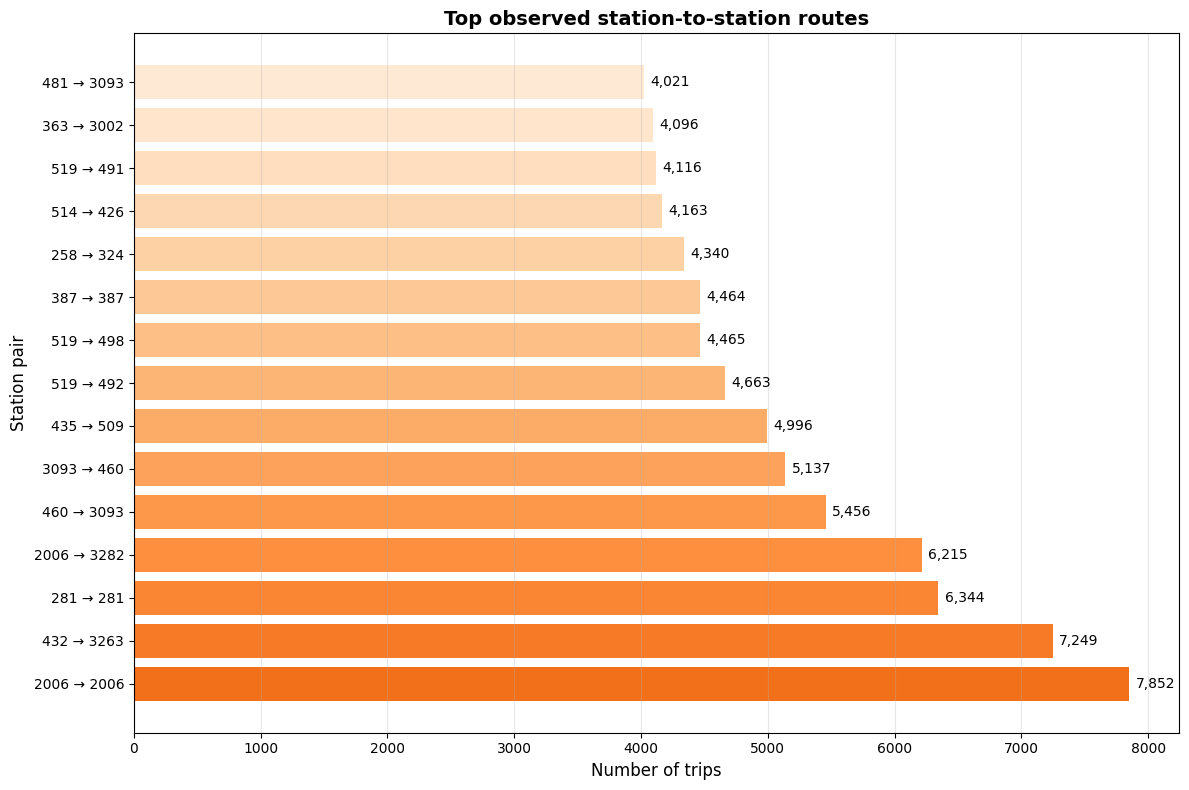


--- GRAPH 2: BIDIRECTIONAL ROUTE PAIRS ---

Top 10 Bidirectional Pairs (Both Directions):
 1. Stations 3093 ↔ 460:
    Forward: 5,137 | Backward: 5,456 | Total: 10,593
    Imbalance: 319 bikes
 2. Stations 3263 ↔ 432:
    Forward: 3,138 | Backward: 7,249 | Total: 10,387
    Imbalance: 4,111 bikes
 3. Stations 2006 ↔ 3282:
    Forward: 6,215 | Backward: 1,906 | Total: 8,121
    Imbalance: 4,309 bikes
 4. Stations 2006 ↔ 2006:
    Forward: 0 | Backward: 7,852 | Total: 7,852
    Imbalance: 7,852 bikes
 5. Stations 3002 ↔ 363:
    Forward: 3,720 | Backward: 4,096 | Total: 7,816
    Imbalance: 376 bikes
 6. Stations 492 ↔ 519:
    Forward: 2,966 | Backward: 4,663 | Total: 7,629
    Imbalance: 1,697 bikes
 7. Stations 435 ↔ 509:
    Forward: 4,996 | Backward: 2,597 | Total: 7,593
    Imbalance: 2,399 bikes
 8. Stations 3258 ↔ 494:
    Forward: 3,572 | Backward: 3,879 | Total: 7,451
    Imbalance: 307 bikes
 9. Stations 3086 ↔ 3430:
    Forward: 3,461 | Backward: 3,982 | Total: 7,443
    Imb

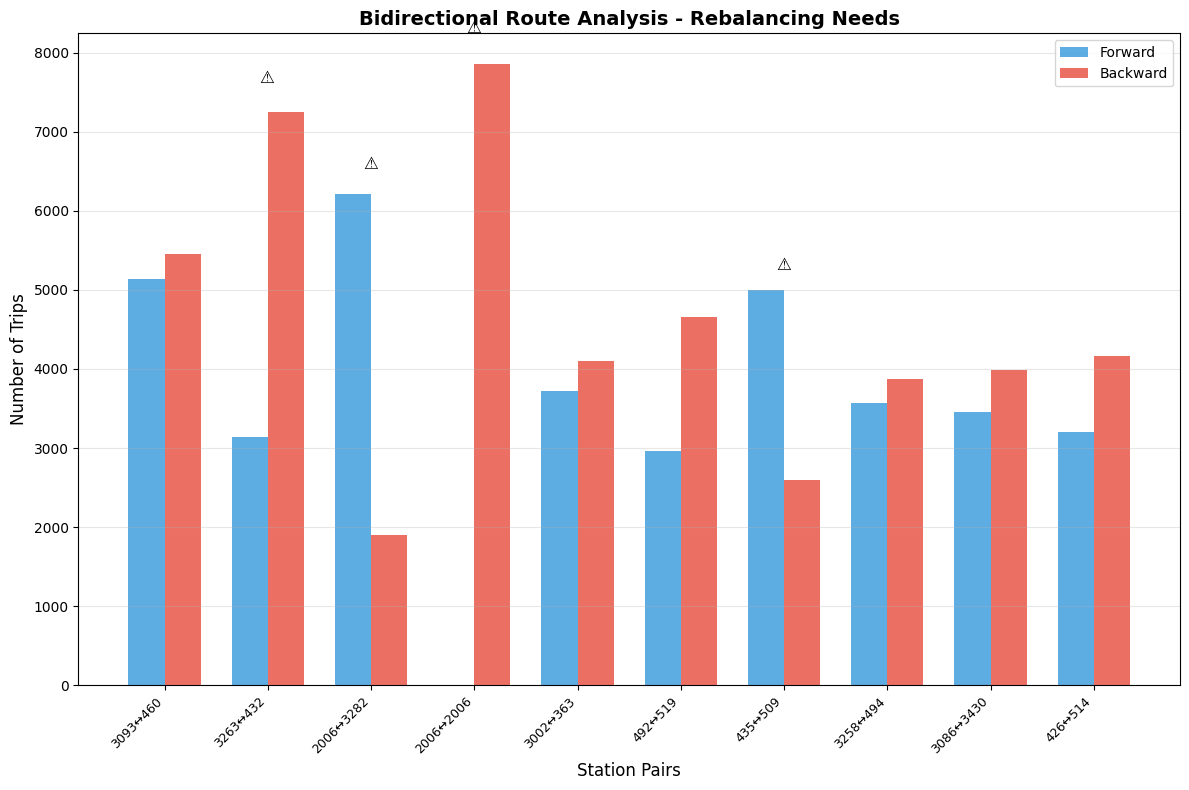


--- GRAPH 3: ZONE-TO-ZONE MOVEMENT PATTERNS ---

Top Zone-to-Zone Connections:
 1. start_zone_D → end_zone_D: 13,004 trips
 2. start_zone_C → end_zone_C: 6,812 trips
 3. start_zone_B → end_zone_B: 4,561 trips
 4. start_zone_D → end_zone_C: 4,362 trips
 5. start_zone_C → end_zone_D: 4,207 trips
 6. start_zone_C → end_zone_B: 3,516 trips
 7. start_zone_B → end_zone_C: 3,402 trips
 8. start_zone_B → end_zone_D: 3,136 trips
 9. start_zone_D → end_zone_B: 3,066 trips
10. start_zone_C → end_zone_A: 703 trips


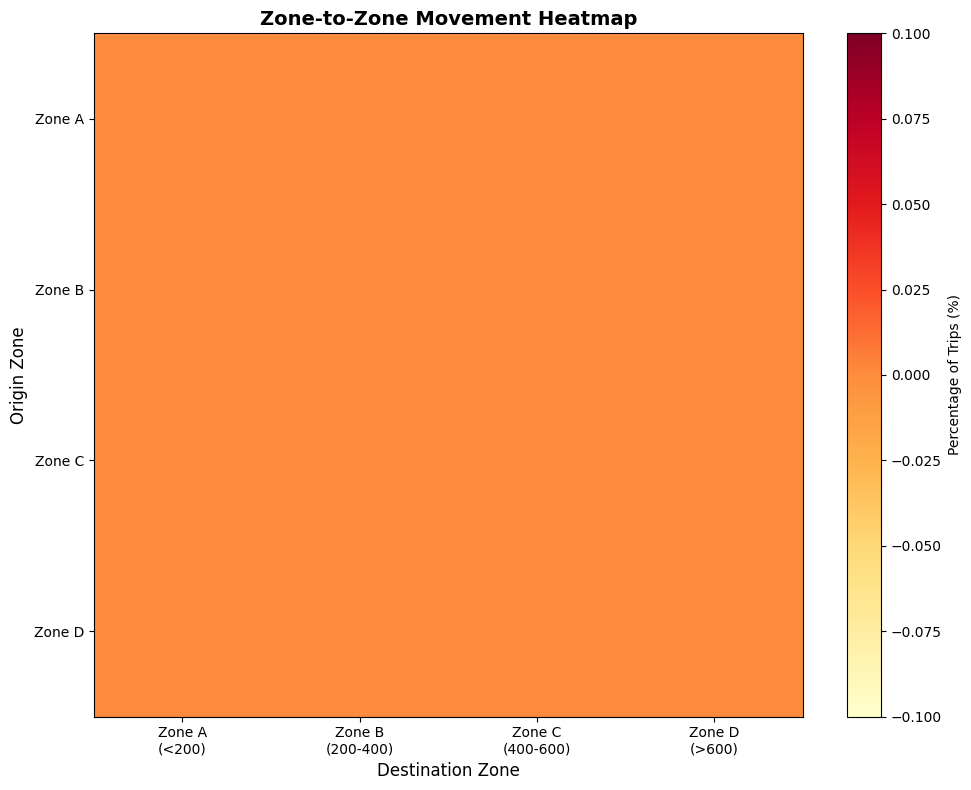


--- GRAPH 4: ASSOCIATION RULE PAIRS ---

Top 10 Association Rule Pairs (IF-THEN):

IF morning_commute
THEN good_weather
  Support: 0.015 | Confidence: 7.96% | Lift: 1.80

IF good_weather
THEN morning_commute
  Support: 0.015 | Confidence: 34.30% | Lift: 1.80

IF end_zone_B & non_commute
THEN poor_weather & start_zone_B
  Support: 0.050 | Confidence: 38.44% | Lift: 1.71

IF poor_weather & start_zone_B
THEN end_zone_B & non_commute
  Support: 0.050 | Confidence: 22.17% | Lift: 1.71

IF end_zone_B
THEN morning_commute & poor_weather & start_zone_B
  Support: 0.016 | Confidence: 6.74% | Lift: 1.71

IF morning_commute & poor_weather & start_zone_B
THEN end_zone_B
  Support: 0.016 | Confidence: 40.18% | Lift: 1.71

IF morning_commute & start_zone_B
THEN end_zone_B
  Support: 0.017 | Confidence: 40.14% | Lift: 1.70

IF end_zone_B
THEN morning_commute & start_zone_B
  Support: 0.017 | Confidence: 7.26% | Lift: 1.70

IF end_zone_B & poor_weather & non_commute
THEN start_zone_B
  Support: 0.050

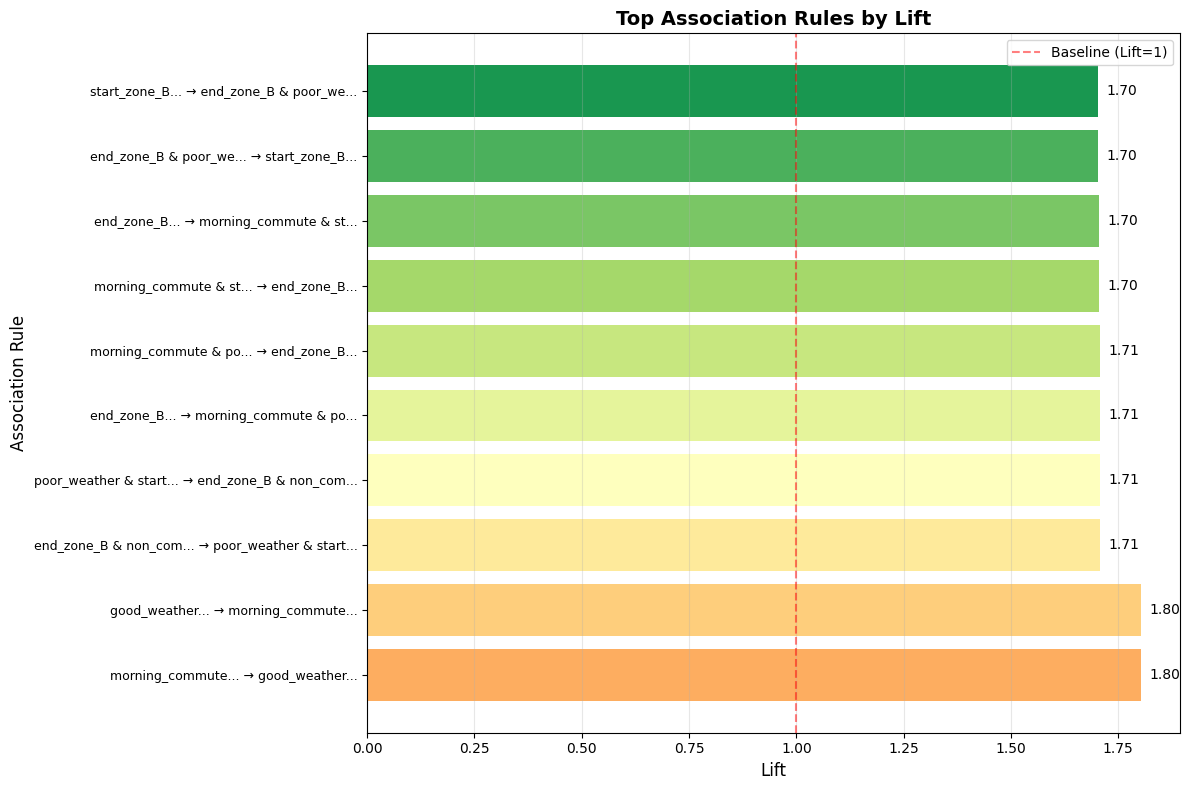


--- GRAPH 5: COMMUTE PATTERN DISTRIBUTION ---

Commute Pattern Statistics:
Morning Rush (7-9 AM): 3,332,116 trips (19.0%)
Evening Rush (5-7 PM): 4,463,897 trips (25.4%)
Non-Commute Hours: 9,749,829 trips (55.6%)


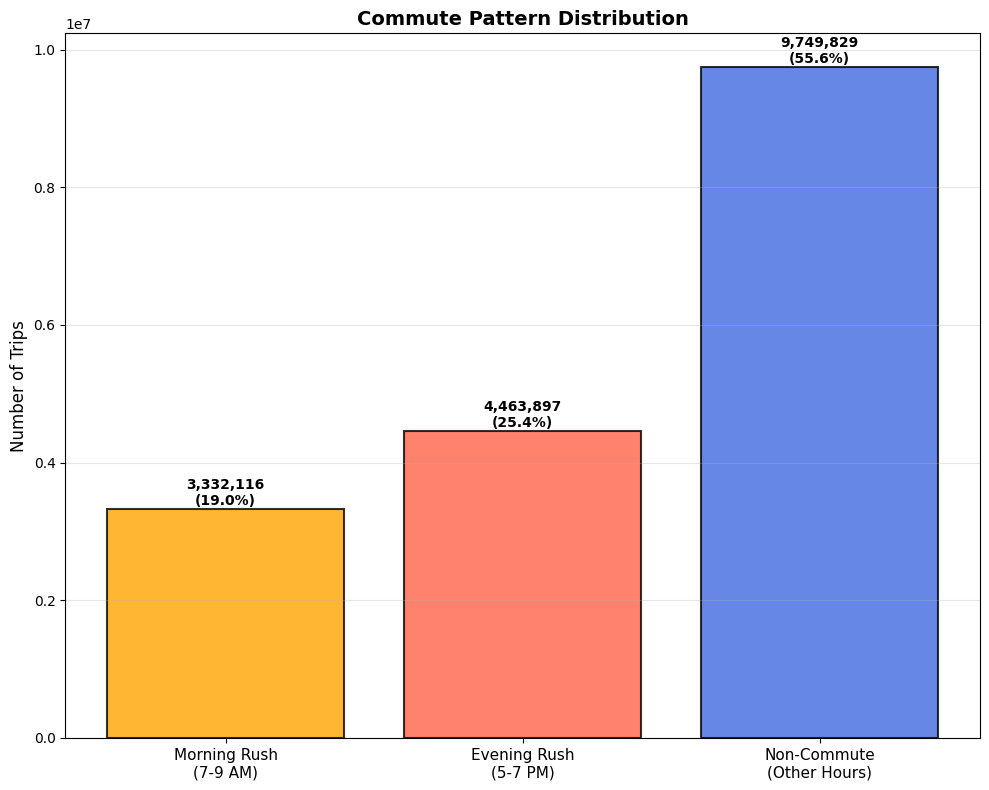


SUMMARY: ALL DISCOVERED PAIRS AND PATTERNS

1. Station Pairs: 347869 unique routes discovered
2. Bidirectional Pairs: 201016 analyzed
3. Zone Connections: 16 patterns found
4. Association Rules: 180 generated
5. Frequent Patterns: 158 discovered

Key Insights for Social Impact:
- Rush hours account for 44.4% of trips
- Top route carries 0.04% of total traffic
- Rebalancing needed for 4 station pairs


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


print("\n" + "="*70)
print("COMPREHENSIVE PATTERN ANALYSIS WITH VISUALIZATIONS")
print("="*70)

# =====================================
# GRAPH 1: TOP OBSERVED ROUTES
# =====================================
print("\n--- GRAPH 1: TOP STATION-TO-STATION ROUTES ---")

# Get top 15 routes
top_15_routes = sorted(route_counter.items(), key=lambda x: x[1], reverse=True)[:15]

# Print the pairs
print("\nTop 15 Station Pairs Found:")
for i, (route, count) in enumerate(top_15_routes, 1):
    stations = route.split('_to_')
    print(f"{i:2}. Station {stations[0]} → Station {stations[1]}: {count:,} trips")

# Create visualization
plt.figure(figsize=(12, 8))

route_labels = []
route_counts = []
for route, count in top_15_routes:
    route_labels.append(route.replace('_to_', ' → '))
    route_counts.append(count)

colors = plt.cm.Oranges_r(np.linspace(0.4, 0.9, len(route_labels)))
bars = plt.barh(range(len(route_labels)), route_counts, color=colors)

plt.yticks(range(len(route_labels)), route_labels, fontsize=10)
plt.xlabel('Number of trips', fontsize=12)
plt.ylabel('Station pair', fontsize=12)
plt.title('Top observed station-to-station routes', fontsize=14, fontweight='bold')

# Add value labels
for i, count in enumerate(route_counts):
    plt.text(count + 50, i, f'{count:,}', va='center', fontsize=10)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =====================================
# GRAPH 2: BIDIRECTIONAL PAIRS ANALYSIS
# =====================================
print("\n--- GRAPH 2: BIDIRECTIONAL ROUTE PAIRS ---")

# Find bidirectional pairs
bidirectional_pairs = {}
for route, count in route_counter.items():
    stations = route.split('_to_')
    if len(stations) == 2:
        pair = tuple(sorted([stations[0], stations[1]]))
        if pair not in bidirectional_pairs:
            bidirectional_pairs[pair] = {'forward': 0, 'backward': 0, 'total': 0}
        
        if stations[0] < stations[1]:
            bidirectional_pairs[pair]['forward'] = count
        else:
            bidirectional_pairs[pair]['backward'] = count
        bidirectional_pairs[pair]['total'] += count

# Get top 10 bidirectional pairs
top_pairs = sorted(bidirectional_pairs.items(), key=lambda x: x[1]['total'], reverse=True)[:10]

# Print bidirectional pairs
print("\nTop 10 Bidirectional Pairs (Both Directions):")
for i, ((s1, s2), counts) in enumerate(top_pairs, 1):
    imbalance = abs(counts['forward'] - counts['backward'])
    print(f"{i:2}. Stations {s1} ↔ {s2}:")
    print(f"    Forward: {counts['forward']:,} | Backward: {counts['backward']:,} | Total: {counts['total']:,}")
    print(f"    Imbalance: {imbalance:,} bikes")

# Create visualization
plt.figure(figsize=(12, 8))

pair_labels = []
forward_counts = []
backward_counts = []

for (s1, s2), counts in top_pairs:
    pair_labels.append(f"{s1}↔{s2}")
    forward_counts.append(counts['forward'])
    backward_counts.append(counts['backward'])

x = np.arange(len(pair_labels))
width = 0.35

bars1 = plt.bar(x - width/2, forward_counts, width, label='Forward', color='#3498DB', alpha=0.8)
bars2 = plt.bar(x + width/2, backward_counts, width, label='Backward', color='#E74C3C', alpha=0.8)

plt.xlabel('Station Pairs', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Bidirectional Route Analysis - Rebalancing Needs', fontsize=14, fontweight='bold')
plt.xticks(x, pair_labels, rotation=45, ha='right', fontsize=9)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, axis='y')

# Mark imbalanced pairs
for i, ((s1, s2), counts) in enumerate(top_pairs):
    imbalance = abs(counts['forward'] - counts['backward']) / counts['total']
    if imbalance > 0.3:
        plt.text(i, max(counts['forward'], counts['backward']) * 1.05, '⚠️', 
                ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# =====================================
# GRAPH 3: ZONE FLOW PATTERNS
# =====================================
print("\n--- GRAPH 3: ZONE-TO-ZONE MOVEMENT PATTERNS ---")

# Analyze zone connections from simplified transactions
zone_connections = {}
for trans in simplified_trans:
    start_zones = [item for item in trans if 'start_zone' in item]
    end_zones = [item for item in trans if 'end_zone' in item]
    
    for start in start_zones:
        for end in end_zones:
            pair = f"{start} → {end}"
            zone_connections[pair] = zone_connections.get(pair, 0) + 1

# Print top zone pairs
print("\nTop Zone-to-Zone Connections:")
top_zone_pairs = sorted(zone_connections.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (pair, count) in enumerate(top_zone_pairs, 1):
    print(f"{i:2}. {pair}: {count:,} trips")

# Create zone matrix
zones = ['zone_A', 'zone_B', 'zone_C', 'zone_D']
matrix = np.zeros((4, 4))

for pair, count in zone_connections.items():
    parts = pair.split(' → ')
    if len(parts) == 2:
        start, end = parts
        if start in zones and end in zones:
            i = zones.index(start)
            j = zones.index(end)
            matrix[i, j] = count

# Normalize to percentages
matrix_pct = (matrix / matrix.sum()) * 100 if matrix.sum() > 0 else matrix

# Create visualization
plt.figure(figsize=(10, 8))
im = plt.imshow(matrix_pct, cmap='YlOrRd', aspect='auto')
plt.colorbar(im, label='Percentage of Trips (%)')

zone_labels = ['Zone A\n(<200)', 'Zone B\n(200-400)', 'Zone C\n(400-600)', 'Zone D\n(>600)']
plt.xticks(range(4), zone_labels)
plt.yticks(range(4), ['Zone A', 'Zone B', 'Zone C', 'Zone D'])
plt.xlabel('Destination Zone', fontsize=12)
plt.ylabel('Origin Zone', fontsize=12)
plt.title('Zone-to-Zone Movement Heatmap', fontsize=14, fontweight='bold')

# Add annotations
for i in range(4):
    for j in range(4):
        if matrix_pct[i, j] > 0:
            plt.text(j, i, f'{matrix_pct[i, j]:.1f}%',
                    ha="center", va="center", color="black", fontweight='bold')

plt.tight_layout()
plt.show()

# =====================================
# GRAPH 4: ASSOCIATION RULE PAIRS
# =====================================
print("\n--- GRAPH 4: ASSOCIATION RULE PAIRS ---")

if len(rules) > 0:
    # Print top association rule pairs
    print("\nTop 10 Association Rule Pairs (IF-THEN):")
    top_rules = rules.nlargest(10, 'lift')
    
    rule_pairs = []
    for idx, rule in top_rules.iterrows():
        ant = list(rule['antecedents'])
        cons = list(rule['consequents'])
        ant_str = ' & '.join(ant)
        cons_str = ' & '.join(cons)
        rule_pairs.append({
            'antecedent': ant_str,
            'consequent': cons_str,
            'support': rule['support'],
            'confidence': rule['confidence'],
            'lift': rule['lift']
        })
        print(f"\nIF {ant_str}")
        print(f"THEN {cons_str}")
        print(f"  Support: {rule['support']:.3f} | Confidence: {rule['confidence']:.2%} | Lift: {rule['lift']:.2f}")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Prepare data for bar chart
    rule_labels = []
    lifts = []
    for i, rule_pair in enumerate(rule_pairs[:10]):
        label = f"{rule_pair['antecedent'][:20]}... → {rule_pair['consequent'][:20]}..."
        rule_labels.append(label)
        lifts.append(rule_pair['lift'])
    
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rule_labels)))
    bars = plt.barh(range(len(rule_labels)), lifts, color=colors)
    
    plt.yticks(range(len(rule_labels)), rule_labels, fontsize=9)
    plt.xlabel('Lift', fontsize=12)
    plt.ylabel('Association Rule', fontsize=12)
    plt.title('Top Association Rules by Lift', fontsize=14, fontweight='bold')
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.5, label='Baseline (Lift=1)')
    
    # Add value labels
    for i, lift in enumerate(lifts):
        plt.text(lift + 0.02, i, f'{lift:.2f}', va='center', fontsize=10)
    
    plt.legend()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("No association rules found")

# =====================================
# GRAPH 5: COMMUTE PATTERNS
# =====================================
print("\n--- GRAPH 5: COMMUTE PATTERN DISTRIBUTION ---")

total_trans = len(all_transactions)

# Print commute statistics
print("\nCommute Pattern Statistics:")
print(f"Morning Rush (7-9 AM): {commute_patterns['morning']:,} trips ({commute_patterns['morning']/total_trans*100:.1f}%)")
print(f"Evening Rush (5-7 PM): {commute_patterns['evening']:,} trips ({commute_patterns['evening']/total_trans*100:.1f}%)")
print(f"Non-Commute Hours: {commute_patterns['non_commute']:,} trips ({commute_patterns['non_commute']/total_trans*100:.1f}%)")

# Create visualization
plt.figure(figsize=(10, 8))

categories = ['Morning Rush\n(7-9 AM)', 'Evening Rush\n(5-7 PM)', 'Non-Commute\n(Other Hours)']
values = [commute_patterns['morning'], commute_patterns['evening'], commute_patterns['non_commute']]
colors = ['#FFA500', '#FF6347', '#4169E1']

bars = plt.bar(range(len(categories)), values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xticks(range(len(categories)), categories, fontsize=11)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Commute Pattern Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add labels
for i, (bar, value) in enumerate(zip(bars, values)):
    pct = value/total_trans*100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50000,
            f'{value:,}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


# =====================================
# FINAL SUMMARY
# =====================================
print("\n" + "="*70)
print("SUMMARY: ALL DISCOVERED PAIRS AND PATTERNS")
print("="*70)

print(f"\n1. Station Pairs: {len(route_counter)} unique routes discovered")
print(f"2. Bidirectional Pairs: {len(bidirectional_pairs)} analyzed")
print(f"3. Zone Connections: {len(zone_connections)} patterns found")
print(f"4. Association Rules: {len(rules) if 'rules' in locals() else 0} generated")
print(f"5. Frequent Patterns: {len(frequent_itemsets)} discovered")

print("\nKey Insights for Social Impact:")
print(f"- Rush hours account for {(commute_patterns['morning']+commute_patterns['evening'])/total_trans*100:.1f}% of trips")
print(f"- Top route carries {top_15_routes[0][1]/total_trans*100:.2f}% of total traffic")
print(f"- Rebalancing needed for {sum(1 for p in top_pairs if abs(p[1]['forward']-p[1]['backward'])/p[1]['total'] > 0.3)} station pairs")

# Finalize User Profiles


In [11]:
print("\n" + "="*70)
print("USER CLUSTERING - AGGREGATING PROFILES")
print("="*70)

# Combine all batch profiles
all_profiles = pd.concat(user_profiles_list, ignore_index=True)

# Final aggregation
user_profiles = all_profiles.groupby(['birth_year', 'gender']).agg({
    ('tripduration', 'mean'): 'mean',
    ('tripduration', 'std'): 'mean',
    ('tripduration', 'count'): 'sum',
    ('trip_duration_min', 'mean'): 'mean',
    ('trip_duration_min', 'median'): 'mean',
    ('start_station_id', 'nunique'): 'max',
    ('end_station_id', 'nunique'): 'max',
    ('hour', 'mean'): 'mean',
    ('hour', 'std'): 'mean',
    ('is_weekend', 'mean'): 'mean',
    ('day_of_week', '<lambda>'): 'mean',
    ('cycling_score', 'mean'): 'mean',
    ('cycling_score', 'std'): 'mean',
    ('temp_celsius', 'mean'): 'mean',
    ('is_dry', 'mean'): 'mean',
    ('usertype', '<lambda>'): 'mean'
}).reset_index()

# Rename columns
user_profiles.columns = [
    'birth_year', 'gender', 'avg_duration', 'std_duration', 'trip_count',
    'avg_trip_min', 'median_trip_min', 'unique_start_stations', 'unique_end_stations',
    'avg_hour', 'std_hour', 'weekend_ratio', 'preferred_day',
    'avg_cycling_score', 'std_cycling_score', 'avg_temp_preference', 
    'dry_weather_ratio', 'is_subscriber'
]

# Add derived features
user_profiles['age'] = 2018 - user_profiles['birth_year']
user_profiles['station_diversity'] = (user_profiles['unique_start_stations'] + 
                                      user_profiles['unique_end_stations']) / 2
user_profiles['trips_per_month'] = user_profiles['trip_count'] / 3

# Clean data
user_profiles_clean = user_profiles.dropna()
print(f"User profiles created: {len(user_profiles_clean)} unique user groups")
print(f"From {user_profiles_clean['trip_count'].sum():.0f} total trips")


USER CLUSTERING - AGGREGATING PROFILES
User profiles created: 263 unique user groups
From 17548326 total trips


# Hierarchical Clustering


In [12]:
print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING ANALYSIS")
print("="*70)

# Select features
clustering_features = [
    'age', 'avg_duration', 'trip_count', 'station_diversity',
    'avg_trip_min', 'weekend_ratio', 'avg_hour',
    'avg_cycling_score', 'dry_weather_ratio', 'trips_per_month'
]

available_features = [col for col in clustering_features if col in user_profiles_clean.columns]
X = user_profiles_clean[available_features].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Clustering matrix: {X_scaled.shape}")

# Find best linkage method
linkage_methods = ['ward', 'average', 'complete']
best_method = None
best_score = float('inf')

for method in linkage_methods:
    linkage_test = linkage(X_scaled, method=method)
    clusters_test = fcluster(linkage_test, 4, criterion='maxclust')
    db_score = davies_bouldin_score(X_scaled, clusters_test)
    print(f"  {method}: Davies-Bouldin = {db_score:.3f}")
    if db_score < best_score:
        best_score = db_score
        best_method = method

print(f"\nBest method: {best_method}")

# Perform clustering
linkage_matrix = linkage(X_scaled, method=best_method)

# Find optimal k
db_scores = []
sil_scores = []
k_range = range(3, 9)

for k in k_range:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    db = davies_bouldin_score(X_scaled, clusters)
    sil = silhouette_score(X_scaled, clusters)
    db_scores.append(db)
    sil_scores.append(sil)
    print(f"  k={k}: DB={db:.3f}, Silhouette={sil:.3f}")

optimal_k = k_range[np.argmin(db_scores)]
print(f"\nOptimal clusters: {optimal_k}")

# Final clustering
final_clusters = fcluster(linkage_matrix, optimal_k, criterion='maxclust')
user_profiles_clean['cluster'] = final_clusters


HIERARCHICAL CLUSTERING ANALYSIS
Clustering matrix: (263, 10)
  ward: Davies-Bouldin = 0.910
  average: Davies-Bouldin = 0.151
  complete: Davies-Bouldin = 0.404

Best method: average
  k=3: DB=0.150, Silhouette=0.753
  k=4: DB=0.151, Silhouette=0.740
  k=5: DB=0.276, Silhouette=0.685
  k=6: DB=0.476, Silhouette=0.485
  k=7: DB=0.508, Silhouette=0.472
  k=8: DB=0.557, Silhouette=0.438

Optimal clusters: 3


C:\Users\UPASANA\AppData\Local\Temp\ipykernel_10220\478717859.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profiles_clean['cluster'] = final_clusters


# Visualize Clustering Results


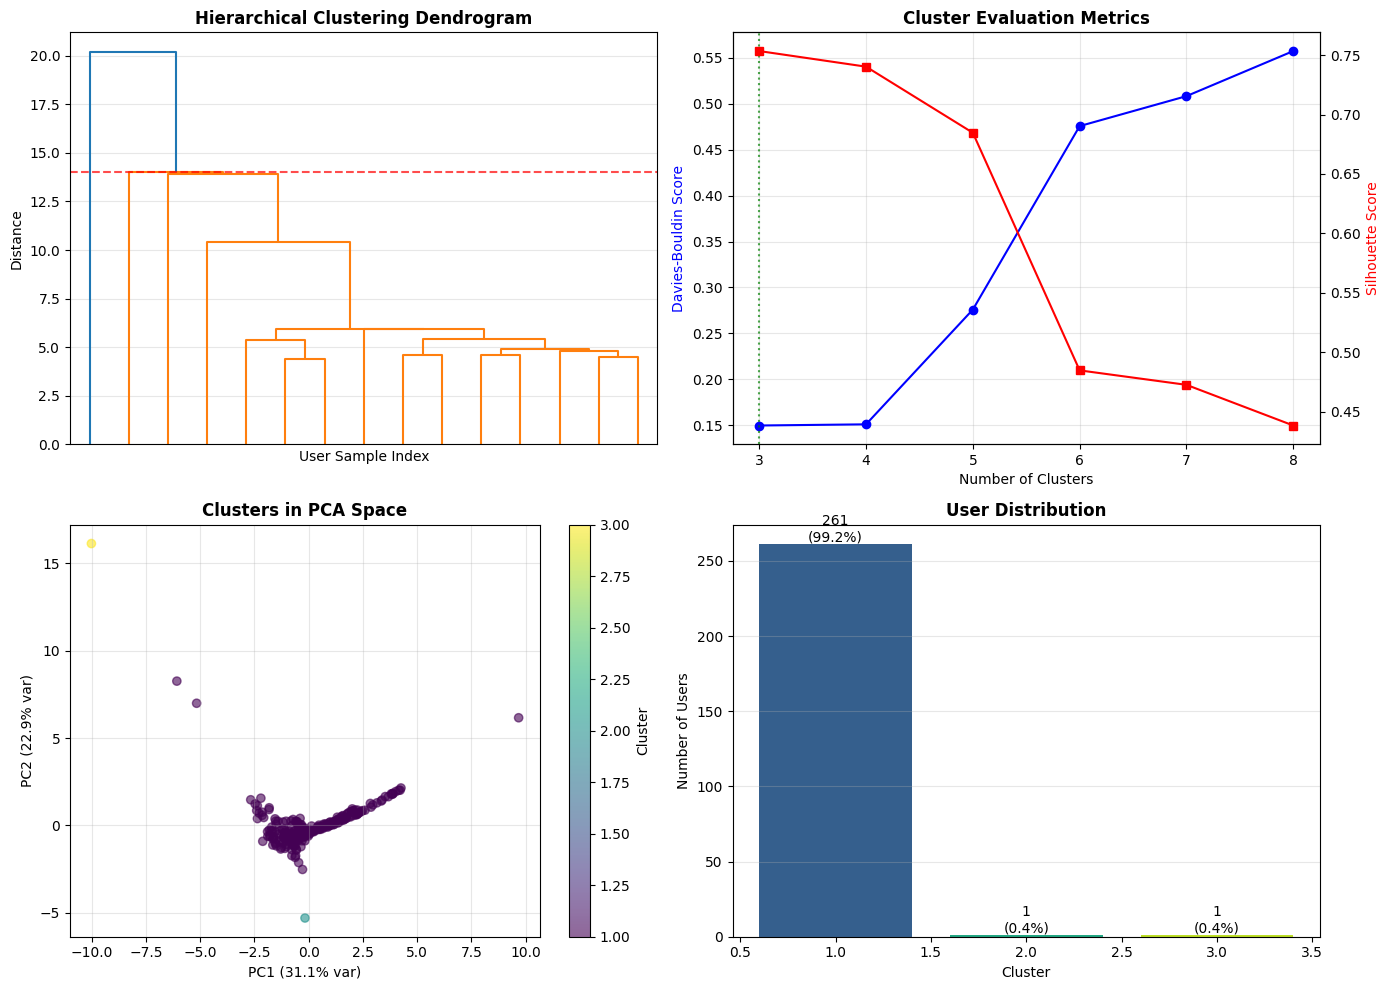

In [13]:
# Add these imports at the top of your notebook
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Then run your visualization code
fig = plt.figure(figsize=(14, 10))

# Dendrogram
ax1 = plt.subplot(2, 2, 1)
dendrogram(linkage_matrix, truncate_mode='lastp', p=15, no_labels=True, ax=ax1)
ax1.axhline(y=linkage_matrix[-(optimal_k-1), 2], color='r', linestyle='--', alpha=0.7)
ax1.set_title('Hierarchical Clustering Dendrogram', fontweight='bold')
ax1.set_xlabel('User Sample Index')
ax1.set_ylabel('Distance')
ax1.grid(True, alpha=0.3)

# Metrics
ax2 = plt.subplot(2, 2, 2)
k_range_plot = list(range(3, 3 + len(db_scores)))
ax2.plot(k_range_plot, db_scores, 'b-o', label='Davies-Bouldin')
ax2_twin = ax2.twinx()
ax2_twin.plot(k_range_plot, sil_scores, 'r-s', label='Silhouette')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Davies-Bouldin Score', color='b')
ax2_twin.set_ylabel('Silhouette Score', color='r')
ax2.axvline(x=optimal_k, color='green', linestyle=':', alpha=0.7)
ax2.set_title('Cluster Evaluation Metrics', fontweight='bold')
ax2.grid(True, alpha=0.3)

# PCA visualization
ax3 = plt.subplot(2, 2, 3)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ax=ax3, label='Cluster')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax3.set_title('Clusters in PCA Space', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Distribution
ax4 = plt.subplot(2, 2, 4)
cluster_sizes = user_profiles_clean['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(cluster_sizes)))
bars = ax4.bar(cluster_sizes.index, cluster_sizes.values, color=colors)
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Number of Users')
ax4.set_title('User Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, cluster_sizes.values):
    pct = count / len(user_profiles_clean) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analyze Clusters

In [14]:
# Analyze each cluster
for cluster_id in range(1, optimal_k + 1):
    cluster = user_profiles_clean[user_profiles_clean['cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}: {len(cluster)} users ({len(cluster)/len(user_profiles_clean)*100:.1f}%)")
    print("-" * 50)
    print(f"Age: {cluster['age'].mean():.1f} years")
    print(f"Trips/month: {cluster['trips_per_month'].mean():.1f}")
    print(f"Trip duration: {cluster['avg_trip_min'].mean():.1f} min")
    print(f"Weekend usage: {cluster['weekend_ratio'].mean():.1%}")
    print(f"Station diversity: {cluster['station_diversity'].mean():.1f}")
    print(f"Weather score: {cluster['avg_cycling_score'].mean():.1f}/100")

# Summary table
cluster_summary = user_profiles_clean.groupby('cluster').agg({
    'age': 'mean',
    'trip_count': 'mean',
    'avg_trip_min': 'mean',
    'weekend_ratio': 'mean',
    'station_diversity': 'mean',
    'avg_cycling_score': 'mean'
}).round(2)

print("\n" + "="*70)
print("CLUSTER SUMMARY")
print("="*70)
print(cluster_summary)
print("\nAnalysis complete!")


CLUSTER 1: 261 users (99.2%)
--------------------------------------------------
Age: 62.8 years
Trips/month: 22411.6
Trip duration: 24.7 min
Weekend usage: 25.0%
Station diversity: 277.9
Weather score: 50.0/100

CLUSTER 2: 1 users (0.4%)
--------------------------------------------------
Age: 91.0 years
Trips/month: 2.3
Trip duration: 20.5 min
Weekend usage: 100.0%
Station diversity: 6.0
Weather score: 30.0/100

CLUSTER 3: 1 users (0.4%)
--------------------------------------------------
Age: 131.0 years
Trips/month: 5.7
Trip duration: 1591.9 min
Weekend usage: 42.2%
Station diversity: 3.5
Weather score: 67.4/100

CLUSTER SUMMARY
            age  trip_count  avg_trip_min  weekend_ratio  station_diversity  \
cluster                                                                       
1         62.82    67234.87         24.73           0.25             277.87   
2         91.00        7.00         20.47           1.00               6.00   
3        131.00       17.00       1591.89    

# Temporal Demand Forecasting


TEMPORAL DEMAND ANALYSIS & PATTERNS

Peak vs Off-Peak Analysis:
        trip_duration_min         start_station_id usertype
                     mean     std            count <lambda>
is_peak                                                    
0                   17.41  343.96          9749829     0.86
1                   15.32  274.33          7796013     0.93


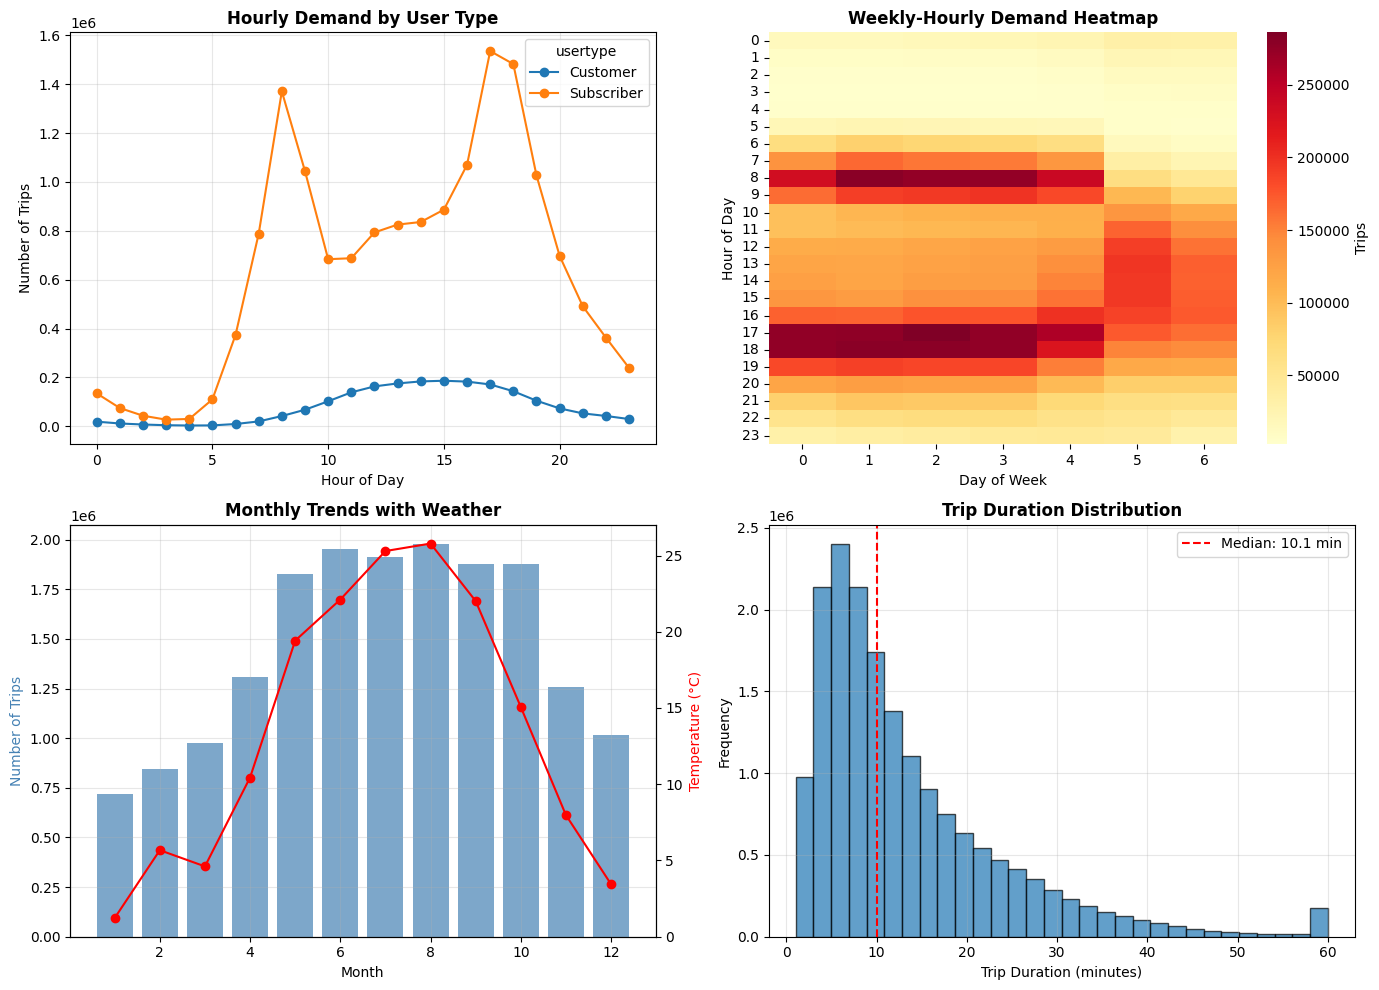

In [15]:
print("\n" + "="*70)
print("TEMPORAL DEMAND ANALYSIS & PATTERNS")
print("="*70)

# Hourly demand patterns by user type
hourly_patterns = dfm.groupby([dfm['start_hour'].dt.hour, 'usertype']).agg({
    'start_station_id': 'count',
    'trip_duration_min': 'mean',
    'cycling_score': 'mean'
}).rename(columns={'start_station_id': 'trips'}).reset_index()

# Peak vs Off-peak analysis
peak_hours = [7, 8, 9, 17, 18, 19]
dfm['is_peak'] = dfm['hour'].isin(peak_hours).astype(int)

peak_analysis = dfm.groupby('is_peak').agg({
    'trip_duration_min': ['mean', 'std'],
    'start_station_id': 'count',
    'usertype': lambda x: (x == 'Subscriber').mean()
}).round(2)

print("\nPeak vs Off-Peak Analysis:")
print(peak_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly pattern by user type
pivot_hourly = hourly_patterns.pivot(index='start_hour', columns='usertype', values='trips')
pivot_hourly.plot(ax=axes[0,0], marker='o')
axes[0,0].set_title('Hourly Demand by User Type', fontweight='bold')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Number of Trips')
axes[0,0].grid(True, alpha=0.3)

# Weekly pattern heatmap
weekly_hourly = dfm.groupby(['day_of_week', 'hour']).size().reset_index(name='trips')
weekly_pivot = weekly_hourly.pivot(index='hour', columns='day_of_week', values='trips')
sns.heatmap(weekly_pivot, cmap='YlOrRd', ax=axes[0,1], cbar_kws={'label': 'Trips'})
axes[0,1].set_title('Weekly-Hourly Demand Heatmap', fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Hour of Day')

# Monthly trend
monthly_trend = dfm.groupby('month').agg({
    'start_station_id': 'count',
    'cycling_score': 'mean',
    'temp_celsius': 'mean'
}).rename(columns={'start_station_id': 'trips'})

ax1 = axes[1,0]
ax1.bar(monthly_trend.index, monthly_trend['trips'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Trips', color='steelblue')
ax1.set_title('Monthly Trends with Weather', fontweight='bold')
ax2 = ax1.twinx()
ax2.plot(monthly_trend.index, monthly_trend['temp_celsius'], 'r-o', label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='red')
ax1.grid(True, alpha=0.3)

# Duration distribution
axes[1,1].hist(dfm['trip_duration_min'].clip(0, 60), bins=30, edgecolor='black', alpha=0.7)
axes[1,1].axvline(dfm['trip_duration_min'].median(), color='red', linestyle='--', label=f'Median: {dfm["trip_duration_min"].median():.1f} min')
axes[1,1].set_xlabel('Trip Duration (minutes)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Trip Duration Distribution', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()